In [ ]:
!pip install py2neo

In [ ]:
!pip install stellargraph

In [3]:
from py2neo.data import Node, Relationship
import py2neo

In [4]:
graph = py2neo.Graph("bolt://0.tcp.ap.ngrok.io:15049", auth=("neo4j", "randomstufF"))

In [5]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.connector.neo4j import Neo4jGraphSAGENodeGenerator, Neo4jStellarGraph
from stellargraph.layer import GraphSAGE

import numpy as np
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import time
%matplotlib inline

In [6]:
# Authors
authors_df = graph.run(
    """
    MATCH (n:Author) RETURN n.name as name
    """).to_data_frame()

In [7]:
(authors_df.drop_duplicates() == authors_df).drop_duplicates()

,name
0,True


In [8]:
authors_df.head()

,name
0,Eun-Kyeong Kwon
1,Yong-Gu Cho
2,Kijoon Chae
3,Dominik Slezak
4,Anthony Brabazon


In [9]:
# To give all the authors a identifier
dic_authors = {}
for i in range(len(authors_df)):
    dic_authors[authors_df['name'][i]] = i

In [10]:
len(dic_authors)

63800

In [11]:
authors_ = list(dic_authors.keys())
dic_authors[authors_[50]]

50

In [12]:
co = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_DIRECT]->(b) RETURN a.name as source,b.name as target 
    """).to_data_frame()

In [13]:
print(co.shape)
co.head()

(120775, 2)


,source,target
0,Eun-Kyeong Kwon,Yong-Gu Cho
1,Eun-Kyeong Kwon,Kijoon Chae
2,Yong-Gu Cho,Kijoon Chae
3,Kijoon Chae,Hyun-Jung Na
4,Kijoon Chae,Ga-Jin Na


In [14]:
cal_colab_direct_df = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_DIRECT]->(b) RETURN a.name as source, b.name as target, r.collaborations
    """).to_data_frame()

In [15]:
print(cal_colab_direct_df.shape)
cal_colab_direct_df.head()

(120775, 3)


,source,target,r.collaborations
0,Eun-Kyeong Kwon,Yong-Gu Cho,2
1,Eun-Kyeong Kwon,Kijoon Chae,2
2,Yong-Gu Cho,Kijoon Chae,2
3,Kijoon Chae,Hyun-Jung Na,1
4,Kijoon Chae,Ga-Jin Na,1


In [16]:
cal_colab_direct_df[cal_colab_direct_df['source'] == 'Kijoon Chae']

,source,target,r.collaborations
3,Kijoon Chae,Hyun-Jung Na,1
4,Kijoon Chae,Ga-Jin Na,1
5,Kijoon Chae,Hayoung Oh,1
6,Kijoon Chae,Jung-Chan Na,1
7,Kijoon Chae,Youngsoo Kim,1
8,Kijoon Chae,Jungchan Nah,1
9,Kijoon Chae,Hyokyung Bahn,1
10,Kijoon Chae,Ok-Kyeung Kim,1
11,Kijoon Chae,Jiyoung Lim,2
12,Kijoon Chae,Myung-Jin Lee,1


In [17]:
# Calculate total collaborations per author (direct)
colab_dic_direct = {}
for i in range(len(cal_colab_direct_df)):
    if dic_authors[cal_colab_direct_df['source'][i]] not in colab_dic_direct.keys():
        colab_dic_direct[dic_authors[cal_colab_direct_df['source'][i]]] = cal_colab_direct_df['r.collaborations'][i]
    else:
        colab_dic_direct[dic_authors[cal_colab_direct_df['source'][i]]] += cal_colab_direct_df['r.collaborations'][i]

    if dic_authors[cal_colab_direct_df['target'][i]]  not in colab_dic_direct.keys():
        colab_dic_direct[dic_authors[cal_colab_direct_df['target'][i]]] = cal_colab_direct_df['r.collaborations'][i]
    else:
        colab_dic_direct[dic_authors[cal_colab_direct_df['target'][i]]] += cal_colab_direct_df['r.collaborations'][i]

In [18]:
print(len(colab_dic_direct))
# colab_dic_direct

60544


In [19]:
cal_colab_cited_df = graph.run(
    """
    MATCH p=(a)-[r:CO_AUTHOR_CITED_FINAL]->(b) RETURN a.name as source, b.name as target, r.collaborations
    """).to_data_frame()

In [20]:
print(cal_colab_cited_df.shape)
cal_colab_cited_df.head()

(60863, 3)


,source,target,r.collaborations
0,Raymond W. Yeung,Song-Nam Hong,3
1,Raymond W. Yeung,Steven Weber,12
2,Raymond W. Yeung,Vladimir Stankovic,3
3,Raymond W. Yeung,Neeharika Marukala,2
4,Raymond W. Yeung,Katherine Morrison,2


In [21]:
cal_colab_cited_df[cal_colab_cited_df['source'] == 'Steven Weber']

,source,target,r.collaborations
9802,Steven Weber,Raymond Hall Yip Louie,2
9803,Steven Weber,Chun-Hung Liu,3
9804,Steven Weber,Junse Lee,2
9805,Steven Weber,Giovanni Luca Torrisi,2
9806,Steven Weber,Aaron B. Wagner,2
9807,Steven Weber,Namyoon Lee,5
9808,Steven Weber,Bertrand M. Hochwald,2
9809,Steven Weber,Dongning Guo,3
9810,Steven Weber,Jeffrey G. Andrews,3
9811,Steven Weber,Matthew R. McKay,2


In [22]:
# Calculate total collaborations per author (cited)
colab_dic_cited = {}
for i in range(len(cal_colab_cited_df)):
    if dic_authors[cal_colab_cited_df['source'][i]] not in colab_dic_cited.keys():
        colab_dic_cited[dic_authors[cal_colab_cited_df['source'][i]]] = cal_colab_cited_df['r.collaborations'][i]
    else:
        colab_dic_cited[dic_authors[cal_colab_cited_df['source'][i]]] += cal_colab_cited_df['r.collaborations'][i]

    if dic_authors[cal_colab_cited_df['target'][i]]  not in colab_dic_cited.keys():
        colab_dic_cited[dic_authors[cal_colab_cited_df['target'][i]]] = cal_colab_cited_df['r.collaborations'][i]
    else:
        colab_dic_cited[dic_authors[cal_colab_cited_df['target'][i]]] += cal_colab_cited_df['r.collaborations'][i]

In [23]:
print(len(colab_dic_cited))
# colab_dic_direct

8868


In [24]:
colab_dic_direct == colab_dic_cited

False

In [25]:
co['source'] = co['source'].apply(lambda x: dic_authors[x])
co['target'] = co['target'].apply(lambda x: dic_authors[x])

In [26]:
co.head()
dff = co
del co

In [27]:
print(dff.shape)
dff.head()

(120775, 2)


,source,target
0,0,1
1,0,2
2,1,2
3,2,59631
4,2,59630


In [28]:
cora_feature_names = [f"f{i}" for i in range(2)]
print(cora_feature_names)

['f0', 'f1']


In [29]:
cols = ['dir_colabs', 'cited_colabs']
idx = [i for i in range(len(dic_authors))]

In [30]:
feat = pd.DataFrame(index=idx, columns=cols)

In [31]:
feat.fillna(0, inplace=True)
feat.head()

,dir_colabs,cited_colabs
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [32]:
for i in range(len(dic_authors)):
    if i in colab_dic_direct.keys():
        feat['dir_colabs'][i] = colab_dic_direct[i]
    else:
        feat['dir_colabs'][i] = 0
        
    if i in colab_dic_cited.keys():
        feat['cited_colabs'][i] = colab_dic_cited[i]
    else:
        feat['cited_colabs'][i] = 0

feat.head()

,dir_colabs,cited_colabs
0,4,0
1,4,0
2,16,0
3,19,0
4,15,0


In [33]:
len(feat['cited_colabs'].drop_duplicates())

489

In [34]:
# Normalise thee feaatures to feed into the moddel
dir_mean = feat['dir_colabs'].mean()
dir_max = feat['dir_colabs'].max()
dir_min = feat['dir_colabs'].min()

cit_mean = feat['cited_colabs'].mean()
cit_max = feat['cited_colabs'].max()
cit_min = feat['cited_colabs'].min()

In [35]:
feat['dir_colabs'] = feat['dir_colabs'].apply(lambda x: ((x - dir_min) / (dir_max - dir_min)))
feat['cited_colabs'] = feat['cited_colabs'].apply(lambda x: ((x - cit_min) / (cit_max - cit_min)))

In [36]:
feat.head(10)

,dir_colabs,cited_colabs
0,0.016667,0.0
1,0.016667,0.0
2,0.066667,0.0
3,0.079167,0.0
4,0.062500,0.0
5,0.016667,0.0
6,0.004167,0.0
7,0.041667,0.0
8,0.016667,0.0
9,0.054167,0.0


In [37]:
# fos features

In [38]:
from tqdm import tqdm
tqdm.pandas()

In [39]:
fos_dff = graph.run("""

MATCH((n:Author)<-[:AUTHOR]-(a:Article))
RETURN n.name as name,apoc.text.join(collect(a.fos),":") as fos,apoc.text.join(collect(a.title)," ") as title
ORDER BY n.name

""").to_data_frame()

In [40]:
fos_dff.head(5)

,name,fos,title
0,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays
1,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...
2,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...
3,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...
4,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...


In [41]:
def get_d(x):
    t = x.split(':')
    dict_val={}
    for i in range(len(t)):
        try:
            if(float(t[i])):
                if(t[i-1] in dict_val):
                    dict_val[t[i-1]].append(t[i])
                else:
                    dict_val[t[i-1]]=[t[i]]
        except:
            pass
    for i in dict_val:
        dict_val[i] = sorted(dict_val[i],reverse=True)
    return dict_val

In [42]:
fos_dff['key'] = fos_dff['fos'].apply(lambda x: get_d(x))

In [43]:
fos_dff.head(10)

,name,fos,title,key
0,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Discrete mathematics': ['0.4204095'], 'Combi..."
1,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Empirical research': ['0.471031338'], 'Clust..."
2,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Versa': ['0.441023469'], 'Business process':..."
3,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Biometrics': ['0.4345782'], 'Minutiae': ['0...."
4,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Discr..."
5,A Hammers,Mutual information:0.406580359:Image segmentat...,Construction and validation of mean shape atla...,"{'Mutual information': ['0.406580359'], 'Image..."
6,A Jakoby,Computational physics:0.4558729:Discrete mathe...,A parallel semi-implicit method for 3D nonline...,"{'Computational physics': ['0.4558729'], 'Disc..."
7,A Kaptein,Computer engineering:0.460699946:Electronic pr...,A model-based approach providing context-sensi...,"{'Computer engineering': ['0.460699946'], 'Ele..."
8,A Leonardis,Image restoration:0.484874457:Initialization:0...,A Physically-Motivated Deformable Model Based ...,"{'Image restoration': ['0.484874457'], 'Initia..."
9,A Min Tjoa,Knowledge management:0.457342237:Personalizati...,Towards the use of ontologies for improving us...,"{'Knowledge management': ['0.457342237'], 'Per..."


In [44]:
fos_dff['key'] = fos_dff['key'].apply(lambda x: {k: v for k, v in sorted(x.items(), key=lambda item: item[1],reverse=True)} )

In [45]:
def get_ten(x):
    y={}
    k=list(x.keys())[:1]
    for i in k:
        y[i]=x[i]    
    return y

fos_dff['sortedkey'] = fos_dff['key'].apply(lambda x:get_ten(x))

In [46]:
fos_dff.head(10)

,name,fos,title,key,sortedkey
0,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Matrix (mathematics)': ['0.4815577'], 'Radar...",{'Matrix (mathematics)': ['0.4815577']}
1,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Cluster analysis': ['0.547445059'], 'Evoluti...",{'Cluster analysis': ['0.547445059']}
2,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Transaction log': ['0.555015'], 'Conformance...",{'Transaction log': ['0.555015']}
3,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Minutiae': ['0.700131357'], 'Fingerprint rec...",{'Minutiae': ['0.700131357']}
4,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Class...",{'Image segmentation': ['0.619028568']}
5,A Hammers,Mutual information:0.406580359:Image segmentat...,Construction and validation of mean shape atla...,"{'Image segmentation': ['0.601378739'], 'Compu...",{'Image segmentation': ['0.601378739']}
6,A Jakoby,Computational physics:0.4558729:Discrete mathe...,A parallel semi-implicit method for 3D nonline...,{'Computational magnetohydrodynamics': ['0.684...,{'Computational magnetohydrodynamics': ['0.684...
7,A Kaptein,Computer engineering:0.460699946:Electronic pr...,A model-based approach providing context-sensi...,"{'Electronic program guide': ['0.55619055'], '...",{'Electronic program guide': ['0.55619055']}
8,A Leonardis,Image restoration:0.484874457:Initialization:0...,A Physically-Motivated Deformable Model Based ...,"{'Watershed': ['0.5677321'], 'Image segmentati...",{'Watershed': ['0.5677321']}
9,A Min Tjoa,Knowledge management:0.457342237:Personalizati...,Towards the use of ontologies for improving us...,"{'Efficient XML Interchange': ['0.716740966'],...",{'Efficient XML Interchange': ['0.716740966']}


In [47]:
fos_dff['sortedkey'][0].keys()

dict_keys(['Matrix (mathematics)'])

In [48]:
kk = set()
for i in range(len(fos_dff)):
    for k in fos_dff['sortedkey'][i].keys():
        kk.add(k)

In [49]:
len(kk)

7833

In [50]:
kkk = list()
for i in range(len(fos_dff)):
    for k in fos_dff['sortedkey'][i].keys():
        kkk.append(k)

In [51]:
print(len(kkk))
print(len(set(kkk)))

63318
7833


In [52]:
fos_dff['FOS_BEST'] = fos_dff['sortedkey'].apply(lambda x: list(x.keys()))

In [53]:
print(fos_dff['FOS_BEST'][0])
print(fos_dff['FOS_BEST'][63798])

['Matrix (mathematics)']
['Pattern matching']


In [54]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [55]:
s = fos_dff['FOS_BEST']
s = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=fos_dff.index)

In [56]:
# Drop the columns with noise (decimal col names)
cols_to_remove = []
for col in list(s.columns):
  if col.replace('.','',1).isdigit():
    cols_to_remove.append(col)

print(len(list(s.columns)))
s.drop(columns=cols_to_remove, axis=1, inplace=True)
print(len(list(s.columns)))
# cols = list(s.columns)
# print(cols[4])
# print(type(cols[4]))
# print(cols[4].isdecimal())
# tmp = cols[4]
# print(tmp.replace('.','',1).isdigit())

7833
7738


In [57]:
# print(list(s.columns))
s.columns

Index(['#P-complete', '#SAT', '1-center problem', '1-planar graph',
       '10-foot user interface', '2D Filters', '3-dimensional matching',
       '3D computer graphics', '3D pose estimation', '3D reconstruction',
       ...
       'splice', 'strictfp', 'tf–idf', 'traceroute', 'utm theorem', 'xUnit',
       'Łukasiewicz logic', 'ε-quadratic form', 'μ operator', 'ω-automaton'],
      dtype='object', length=7738)

In [58]:
# s['0.0'].drop_duplicates()

In [59]:
fos_dff['sortedkey'][45562].keys()

dict_keys(['0.0'])

In [60]:
s.head()

,#P-complete,#SAT,1-center problem,1-planar graph,10-foot user interface,2D Filters,3-dimensional matching,3D computer graphics,3D pose estimation,3D reconstruction,3D single-object recognition,3G MIMO,3rd Generation Partnership Project 2,40-bit encryption,56-bit encryption,8-bit color,A Symbolic Analysis of Relay and Switching Circuits,A-DNA,AES implementations,AI-complete,AIBO,AIML,AISoy1,AN codes,API testing,APX,ARINC 661,ASDE-X,ASTERIX,AVL tree,AX.25,Ab initio,Abductive logic programming,Abductive reasoning,Abelian group,Absolute geometry,Abstract data type,Abstract family of languages,Abstract interpretation,Abstract machine,...,Zero-dimensional space,Zero-forcing precoding,Zero-knowledge password proof,Zero-knowledge proof,Zeroth-order logic,Zeta-TCP,Zipf's law,Zipf–Mandelbrot law,Zona pellucida,Zone Routing Protocol,Zoom,c space,cXML,clone (Java method),const,d-ary heap,dBc,e-Science,eHealth,eSTREAM,ecash,gpsOne,k-means clustering,k-medians clustering,k-minimum spanning tree,k-nearest neighbors algorithm,m-derived filter,mmap,occam,scanf format string,splice,strictfp,tf–idf,traceroute,utm theorem,xUnit,Łukasiewicz logic,ε-quadratic form,μ operator,ω-automaton
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
fos_dff.head()

,name,fos,title,key,sortedkey,FOS_BEST
0,A Aart Blokhuis,Discrete mathematics:0.4204095:Combinatorics:0...,Bounds for the size of radar arrays,"{'Matrix (mathematics)': ['0.4815577'], 'Radar...",{'Matrix (mathematics)': ['0.4815577']},[Matrix (mathematics)]
1,A Alejandro Montes Garcia,Empirical research:0.471031338:Cluster analysi...,Effects of Evolutionary Linguistics in Text Cl...,"{'Cluster analysis': ['0.547445059'], 'Evoluti...",{'Cluster analysis': ['0.547445059']},[Cluster analysis]
2,A Anne Rozinat,Versa:0.441023469:Business process:0.4714488:T...,Conformance testing : Measuring the fit and ap...,"{'Transaction log': ['0.555015'], 'Conformance...",{'Transaction log': ['0.555015']},[Transaction log]
3,A Arakala,Biometrics:0.4345782:Minutiae:0.700131357:Fing...,Fuzzy extractors for minutiae-based fingerprin...,"{'Minutiae': ['0.700131357'], 'Fingerprint rec...",{'Minutiae': ['0.700131357']},[Minutiae]
4,A Campilho,Image segmentation:0.619028568:Discrete mathem...,Automatic image segmentation using a deformabl...,"{'Image segmentation': ['0.619028568'], 'Class...",{'Image segmentation': ['0.619028568']},[Image segmentation]


In [62]:
fos_dff.drop(columns=["fos", "title", "key", "sortedkey", "FOS_BEST"], axis=1, inplace=True)
fos_dff.head()

,name
0,A Aart Blokhuis
1,A Alejandro Montes Garcia
2,A Anne Rozinat
3,A Arakala
4,A Campilho


In [63]:
horizontal_feature = pd.concat([fos_dff, s], axis=1)

In [64]:
horizontal_feature.head(10)

,name,#P-complete,#SAT,1-center problem,1-planar graph,10-foot user interface,2D Filters,3-dimensional matching,3D computer graphics,3D pose estimation,3D reconstruction,3D single-object recognition,3G MIMO,3rd Generation Partnership Project 2,40-bit encryption,56-bit encryption,8-bit color,A Symbolic Analysis of Relay and Switching Circuits,A-DNA,AES implementations,AI-complete,AIBO,AIML,AISoy1,AN codes,API testing,APX,ARINC 661,ASDE-X,ASTERIX,AVL tree,AX.25,Ab initio,Abductive logic programming,Abductive reasoning,Abelian group,Absolute geometry,Abstract data type,Abstract family of languages,Abstract interpretation,...,Zero-dimensional space,Zero-forcing precoding,Zero-knowledge password proof,Zero-knowledge proof,Zeroth-order logic,Zeta-TCP,Zipf's law,Zipf–Mandelbrot law,Zona pellucida,Zone Routing Protocol,Zoom,c space,cXML,clone (Java method),const,d-ary heap,dBc,e-Science,eHealth,eSTREAM,ecash,gpsOne,k-means clustering,k-medians clustering,k-minimum spanning tree,k-nearest neighbors algorithm,m-derived filter,mmap,occam,scanf format string,splice,strictfp,tf–idf,traceroute,utm theorem,xUnit,Łukasiewicz logic,ε-quadratic form,μ operator,ω-automaton
0,A Aart Blokhuis,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,A Alejandro Montes Garcia,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,A Anne Rozinat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,A Arakala,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,A Campilho,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,A Hammers,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,A Jakoby,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,A Kaptein,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,A Leonardis,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,A Min Tjoa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
horizontal_feature.shape

(63800, 7739)

In [66]:
del fos_dff
del s

In [67]:
horizontal_feature['name'] = horizontal_feature['name'].apply(lambda x: dic_authors[x])

In [68]:
horizontal_feature.head()

,name,#P-complete,#SAT,1-center problem,1-planar graph,10-foot user interface,2D Filters,3-dimensional matching,3D computer graphics,3D pose estimation,3D reconstruction,3D single-object recognition,3G MIMO,3rd Generation Partnership Project 2,40-bit encryption,56-bit encryption,8-bit color,A Symbolic Analysis of Relay and Switching Circuits,A-DNA,AES implementations,AI-complete,AIBO,AIML,AISoy1,AN codes,API testing,APX,ARINC 661,ASDE-X,ASTERIX,AVL tree,AX.25,Ab initio,Abductive logic programming,Abductive reasoning,Abelian group,Absolute geometry,Abstract data type,Abstract family of languages,Abstract interpretation,...,Zero-dimensional space,Zero-forcing precoding,Zero-knowledge password proof,Zero-knowledge proof,Zeroth-order logic,Zeta-TCP,Zipf's law,Zipf–Mandelbrot law,Zona pellucida,Zone Routing Protocol,Zoom,c space,cXML,clone (Java method),const,d-ary heap,dBc,e-Science,eHealth,eSTREAM,ecash,gpsOne,k-means clustering,k-medians clustering,k-minimum spanning tree,k-nearest neighbors algorithm,m-derived filter,mmap,occam,scanf format string,splice,strictfp,tf–idf,traceroute,utm theorem,xUnit,Łukasiewicz logic,ε-quadratic form,μ operator,ω-automaton
0,26121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,34806,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35266,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3338,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,61889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
# Add features from feat df
cited_colab_feat = pd.DataFrame()
cited_colab_feat['cited_colabs'] = feat['cited_colabs']
horizontal_feature['cited_colabs'] = feat['cited_colabs']
for i in tqdm(range(len(horizontal_feature))):
  cited_colab_feat['cited_colabs'][i] = feat['cited_colabs'][horizontal_feature['name'][i]]

horizontal_feature['cited_colabs'] = cited_colab_feat['cited_colabs']
len(horizontal_feature['cited_colabs'].drop_duplicates())

100%|██████████| 63800/63800 [00:04<00:00, 15731.51it/s]


489

In [70]:
horizontal_feature.set_index("name", inplace=True)

In [71]:
horizontal_feature.head()

,#P-complete,#SAT,1-center problem,1-planar graph,10-foot user interface,2D Filters,3-dimensional matching,3D computer graphics,3D pose estimation,3D reconstruction,3D single-object recognition,3G MIMO,3rd Generation Partnership Project 2,40-bit encryption,56-bit encryption,8-bit color,A Symbolic Analysis of Relay and Switching Circuits,A-DNA,AES implementations,AI-complete,AIBO,AIML,AISoy1,AN codes,API testing,APX,ARINC 661,ASDE-X,ASTERIX,AVL tree,AX.25,Ab initio,Abductive logic programming,Abductive reasoning,Abelian group,Absolute geometry,Abstract data type,Abstract family of languages,Abstract interpretation,Abstract machine,...,Zero-forcing precoding,Zero-knowledge password proof,Zero-knowledge proof,Zeroth-order logic,Zeta-TCP,Zipf's law,Zipf–Mandelbrot law,Zona pellucida,Zone Routing Protocol,Zoom,c space,cXML,clone (Java method),const,d-ary heap,dBc,e-Science,eHealth,eSTREAM,ecash,gpsOne,k-means clustering,k-medians clustering,k-minimum spanning tree,k-nearest neighbors algorithm,m-derived filter,mmap,occam,scanf format string,splice,strictfp,tf–idf,traceroute,utm theorem,xUnit,Łukasiewicz logic,ε-quadratic form,μ operator,ω-automaton,cited_colabs
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000497
34806,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
35266,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
3338,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
61889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000


In [72]:
from stellargraph import StellarGraph

In [73]:
# sg = StellarGraph(feat,edges=dff)
sg = StellarGraph(horizontal_feature,edges=dff)

In [74]:
print(type(sg))
print(sg.info())

<class 'stellargraph.core.graph.StellarGraph'>
StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 120775

 Node types:
  default: [63800]
    Features: float32 vector, length 7739
    Edge types: default-default->default

 Edge types:
    default-default->default: [120775]
        Weights: all 1 (default)
        Features: none


In [75]:
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

In [76]:
edge_splitter_test = EdgeSplitter(sg)

In [77]:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 12077 positive and 12077 negative edges. **


In [78]:
edge_splitter_train = EdgeSplitter(G_test)

In [79]:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 10869 positive and 10869 negative edges. **


In [80]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 97829

 Node types:
  default: [63800]
    Features: float32 vector, length 7739
    Edge types: default-default->default

 Edge types:
    default-default->default: [97829]
        Weights: all 1 (default)
        Features: none


In [81]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 63800, Edges: 108698

 Node types:
  default: [63800]
    Features: float32 vector, length 7739
    Edge types: default-default->default

 Edge types:
    default-default->default: [108698]
        Weights: all 1 (default)
        Features: none


In [82]:
batch_size = 20
epochs = 48

In [83]:
num_samples = [20, 10]

In [84]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)

In [85]:
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [86]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [87]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [88]:
x_inp, x_out = graphsage.in_out_tensors()

In [89]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [90]:
import tensorflow.keras as keras # DO NOT USE KERAS DIRECTLY
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

In [91]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

In [92]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1208/1208 [==============================] - 302s 250ms/step - loss: 0.5194 - acc: 0.7705

Train Set Metrics of the initial (untrained) model:
	loss: 0.5296
	acc: 0.7597

Test Set Metrics of the initial (untrained) model:
	loss: 0.5194
	acc: 0.7705


In [93]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=1)

Epoch 1/48
1087/1087 [==============================] - 594s 546ms/step - loss: 0.4826 - acc: 0.7922 - val_loss: 0.3548 - val_acc: 0.8331
Epoch 2/48
1087/1087 [==============================] - 597s 549ms/step - loss: 0.2837 - acc: 0.9058 - val_loss: 0.3257 - val_acc: 0.8702
Epoch 3/48
1087/1087 [==============================] - 595s 547ms/step - loss: 0.1916 - acc: 0.9493 - val_loss: 0.3383 - val_acc: 0.8807
Epoch 4/48
1087/1087 [==============================] - 599s 551ms/step - loss: 0.1526 - acc: 0.9627 - val_loss: 0.3466 - val_acc: 0.8789
Epoch 5/48
1087/1087 [==============================] - 602s 554ms/step - loss: 0.1264 - acc: 0.9726 - val_loss: 0.3497 - val_acc: 0.8885
Epoch 6/48
1087/1087 [==============================] - 595s 547ms/step - loss: 0.1470 - acc: 0.9528 - val_loss: 0.3611 - val_acc: 0.8598
Epoch 7/48
1087/1087 [==============================] - 587s 540ms/step - loss: 0.1355 - acc: 0.9693 - val_loss: 0.3550 - val_acc: 0.8844
Epoch 8/48
1087/1087 [============

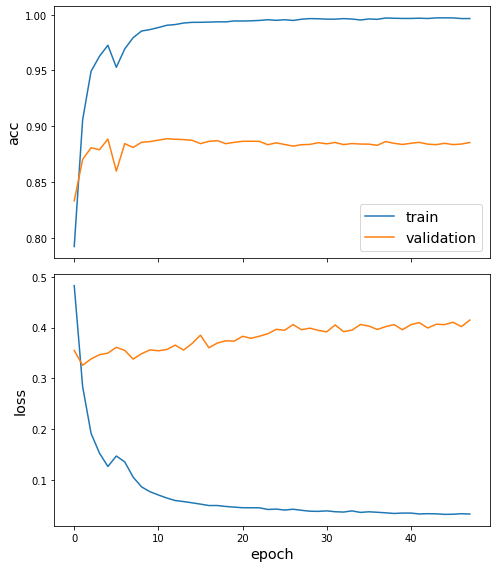

In [94]:
import stellargraph
stellargraph.utils.plot_history(history)

In [95]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1208/1208 [==============================] - 299s 247ms/step - loss: 0.4144 - acc: 0.8847

Train Set Metrics of the trained model:
	loss: 0.0199
	acc: 0.9981

Test Set Metrics of the trained model:
	loss: 0.4144
	acc: 0.8847


In [96]:
print("test_matrics: ", test_metrics)

test_matrics:  [0.41441383957862854, 0.8847395777702332]
